### MaskFormer

![Mask Former](../assets/mask_former.png)

Device set to use mps:0


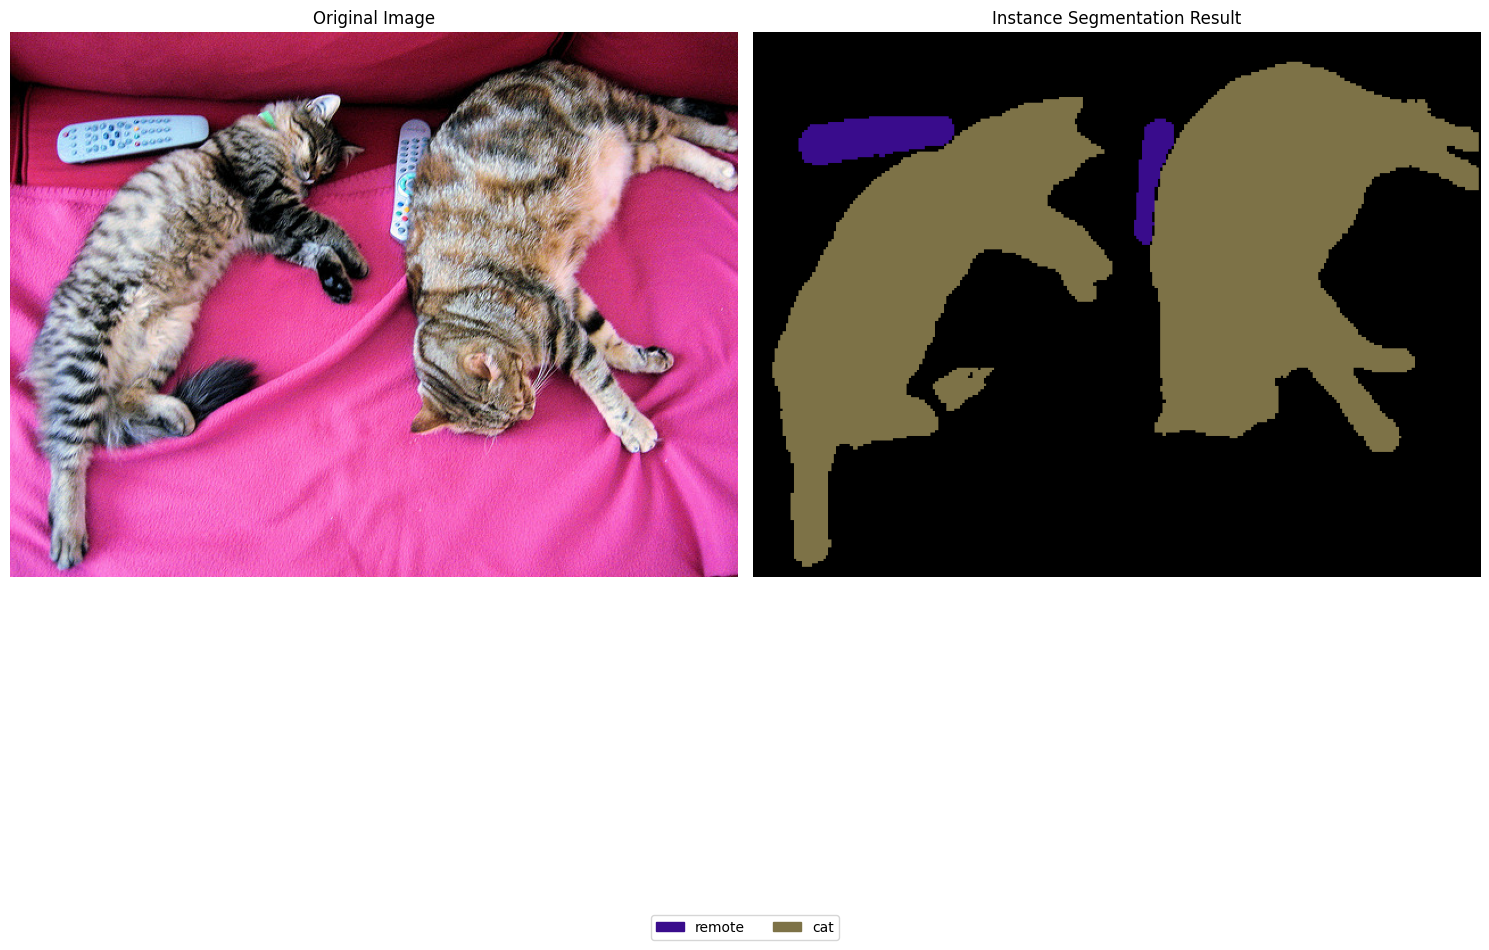

Found 4 segments:
1. remote (Score: 0.9731)
2. cat (Score: 0.9244)
3. cat (Score: 0.9504)
4. remote (Score: 0.9642)


In [12]:
from transformers import pipeline
from PIL import Image, ImageDraw
import requests
import numpy as np
import matplotlib.pyplot as plt
import random

# Load the image
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

# Try instance segmentation instead of panoptic
segmentation = pipeline("image-segmentation", "facebook/maskformer-swin-base-coco")
results = segmentation(images=image, subtask="instance")

# Create a blank RGB image for the segmentation mask
width, height = image.size
mask_img = Image.new('RGB', (width, height), (0, 0, 0))
mask_draw = ImageDraw.Draw(mask_img)

# Generate random colors for each segment
random.seed(42)  # For reproducibility
colors = {}

# Draw each segment with a different color
for segment in results:
    # Get a random color for this segment
    label = segment['label']
    if label not in colors:
        colors[label] = (
            random.randint(0, 255),
            random.randint(0, 255),
            random.randint(0, 255)
        )
    
    # Convert PIL mask to numpy array
    mask = segment['mask']
    
    # Create a colored mask image
    colored_mask = Image.new('RGB', mask.size, colors[label])
    
    # Paste the colored mask onto our result image using the mask itself
    mask_img.paste(colored_mask, (0, 0), mask)

# Display results
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(mask_img)
plt.title("Instance Segmentation Result")
plt.axis('off')

# Add a legend for the segments
legend_elements = []
for label, color in colors.items():
    color_norm = np.array(color) / 255.0  # Normalize color for matplotlib
    legend_elements.append(plt.Rectangle((0, 0), 1, 1, color=color_norm, label=label))

plt.figlegend(handles=legend_elements, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.05))
plt.tight_layout()
plt.subplots_adjust(bottom=0.2)  # Make room for the legend
plt.show()

# Print segment information
print(f"Found {len(results)} segments:")
for i, segment in enumerate(results):
    print(f"{i+1}. {segment['label']} (Score: {segment['score']:.4f})")